In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
from sklearn import tree
import random
from pprint import pprint

In [3]:
def train_test_split(df, test_size):
    
    if isinstance(test_size, float):
        test_size = round(test_size * len(df))

    indices = df.index.tolist()
    test_indices = random.sample(population=indices, k=test_size)

    test_df = df.loc[test_indices]
    train_df = df.drop(test_indices)
    
    return train_df, test_df


def determine_type_of_feature(df):
    
    feature_types = []
    n_unique_values_treshold = 15
    for feature in df.columns:
        if feature != "PlayGolf":
            unique_values = df[feature].unique()
            example_value = unique_values[0]

            if (isinstance(example_value, str)) or (len(unique_values) <= n_unique_values_treshold):
                feature_types.append("categorical")
            else:
                feature_types.append("continuous")
    
    return feature_types

def calculate_accuracy(predictions, labels):
    predictions_correct = predictions == labels
    accuracy = predictions_correct.mean()
    
    return accuracy

In [4]:
def check_purity(data):
    
    label_column = data[:, -1]
    unique_classes = np.unique(label_column)

    if len(unique_classes) == 1:
        return True
    else:
        return False

    
def classify_data(data):
    
    label_column = data[:, -1]
    unique_classes, counts_unique_classes = np.unique(label_column, return_counts=True)

    index = counts_unique_classes.argmax()
    classification = unique_classes[index]
    
    return classification

def get_potential_splits(data, random_subspace):
    
    potential_splits = {}
    _, n_columns = data.shape
    column_indices = list(range(n_columns - 1)) 
    
    if random_subspace and random_subspace <= len(column_indices):
        column_indices = random.sample(population=column_indices, k=random_subspace)
    
    for column_index in column_indices:          
        values = data[:, column_index]
        unique_values = np.unique(values)
        
        potential_splits[column_index] = unique_values
    
    return potential_splits


#lowest
def calculate_entropy(data):
    
    label_column = data[:, -1]
    _, counts = np.unique(label_column, return_counts=True)

    probabilities = counts / counts.sum()
    entropy = sum(probabilities * -np.log2(probabilities))
     
    return entropy


def calculate_overall_entropy(data_below, data_above):
    
    n = len(data_below) + len(data_above)
    p_data_below = len(data_below) / n
    p_data_above = len(data_above) / n

    overall_entropy =  (p_data_below * calculate_entropy(data_below) 
                      + p_data_above * calculate_entropy(data_above))
    
    return overall_entropy


def determine_best_split(data, potential_splits):
    
    overall_entropy = 9999
    for column_index in potential_splits:
        for value in potential_splits[column_index]:
            data_below, data_above = split_data(data, split_column=column_index, split_value=value)
            current_overall_entropy = calculate_overall_entropy(data_below, data_above)
            
            if current_overall_entropy <= overall_entropy:
                overall_entropy = current_overall_entropy
                best_split_column = column_index
                best_split_value = value
    
    return best_split_column, best_split_value


def split_data(data, split_column, split_value):
    
    split_column_values = data[:, split_column]

    type_of_feature = FEATURE_TYPES[split_column]
    if type_of_feature == "continuous":
        data_below = data[split_column_values <= split_value]
        data_above = data[split_column_values >  split_value]
    
    #categorical   
    else:
        data_below = data[split_column_values == split_value]
        data_above = data[split_column_values != split_value]
    
    return data_below, data_above


def decision_tree_algorithm(df, counter=0, min_samples=2, max_depth=5, random_subspace=None):

    if counter == 0:
        global COLUMN_HEADERS, FEATURE_TYPES
        COLUMN_HEADERS = df.columns
        FEATURE_TYPES = determine_type_of_feature(df)
        data = df.values
    else:
        data = df           
    
    if (check_purity(data)) or (len(data) < min_samples) or (counter == max_depth):
        classification = classify_data(data)
        
        return classification


    else:    
        counter += 1

        
        potential_splits = get_potential_splits(data, random_subspace)
        split_column, split_value = determine_best_split(data, potential_splits)
        data_below, data_above = split_data(data, split_column, split_value)
        
        
        if len(data_below) == 0 or len(data_above) == 0:
            classification = classify_data(data)
            return classification
        
        
        feature_name = COLUMN_HEADERS[split_column]
        type_of_feature = FEATURE_TYPES[split_column]
        if type_of_feature == "continuous":
            question = "{} <= {}".format(feature_name, split_value)
            
        #categorical
        else:
            question = "{} = {}".format(feature_name, split_value)
        
        
        sub_tree = {question: []}
        
        
        yes_answer = decision_tree_algorithm(data_below, counter, min_samples, max_depth, random_subspace)
        no_answer = decision_tree_algorithm(data_above, counter, min_samples, max_depth, random_subspace)
        
        
        if yes_answer == no_answer:
            sub_tree = yes_answer
        else:
            sub_tree[question].append(yes_answer)
            sub_tree[question].append(no_answer)
        
        return sub_tree


def predict_example(example, tree):
    question = list(tree.keys())[0]
    feature_name, comparison_operator, value = question.split(" ")

    
    if comparison_operator == "<=":
        if example[feature_name] <= float(value):
            answer = tree[question][0]
        else:
            answer = tree[question][1]
    
    #categorical
    else:
        if str(example[feature_name]) == value:
            answer = tree[question][0]
        else:
            answer = tree[question][1]

   
    if not isinstance(answer, dict):
        return answer
    
    
    else:
        residual_tree = answer
        return predict_example(example, residual_tree)


def decision_tree_predictions(test_df, tree):
    predictions = test_df.apply(predict_example, args=(tree,), axis=1)
    return predictions


In [5]:
df = pd.read_csv("golf_df.csv")
df.head()

,Outlook,Temperature,Humidity,Wind,PlayGolf
0,Sunny,Hot,High,Weak,No
1,Sunny,Hot,High,Strong,No
2,Overcast,Hot,High,Weak,Yes
3,Rainy,Mild,High,Weak,Yes
4,Rainy,Cool,Normal,Weak,Yes


PlayGolf
Yes    0.642857
No     0.357143
Name: proportion, dtype: float64

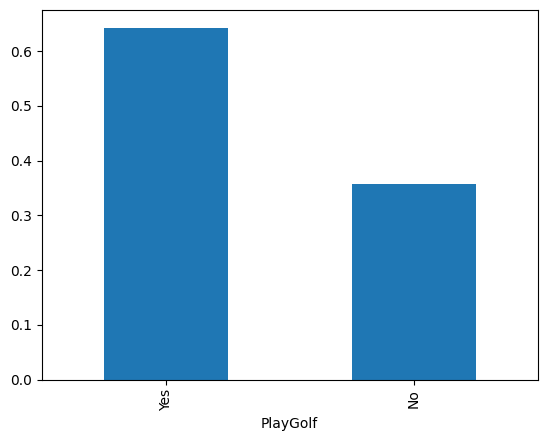

In [6]:
qual = df['PlayGolf'].value_counts(normalize=True)
qual[["Yes", "No"]].plot(kind="bar")
qual

In [7]:
random.seed(0)
train_df, test_df = train_test_split(df, test_size=0.2)

# Random Forest

In [8]:
def bootstrapping(train_df, n_bootstrap):
    bootstrap_indices = np.random.randint(low=0, high=len(train_df), size=n_bootstrap)
    df_bootstrapped = train_df.iloc[bootstrap_indices]
    
    return df_bootstrapped

def random_forest_algorithm(train_df, n_trees, n_bootstrap, n_features, dt_max_depth):
    forest = []
    for i in range(n_trees):
        df_bootstrapped = bootstrapping(train_df, n_bootstrap)
        tree = decision_tree_algorithm(df_bootstrapped, max_depth=dt_max_depth, random_subspace=n_features)
        forest.append(tree)
        print(tree, "\n")
    return forest

def random_forest_predictions(test_df, forest):
    df_predictions = {}
    for i in range(len(forest)):
        column_name = "tree_{}".format(i)
        predictions = decision_tree_predictions(test_df, tree=forest[i])
        df_predictions[column_name] = predictions

    df_predictions = pd.DataFrame(df_predictions)
    random_forest_predictions = df_predictions.mode(axis=1)[0]
    
    return random_forest_predictions

forest = random_forest_algorithm(train_df, n_trees=4, n_bootstrap=800, n_features=2, dt_max_depth=4)
predictions = random_forest_predictions(test_df, forest)

{'Outlook = Sunny': [{'Temperature = Hot': ['No', {'Humidity = Normal': ['Yes', 'No']}]}, {'Wind = Weak': ['Yes', {'Humidity = Normal': ['No', 'Yes']}]}]} 

{'Temperature = Hot': [{'Outlook = Sunny': ['No', 'Yes']}, {'Wind = Weak': [{'Temperature = Mild': [{'Outlook = Sunny': ['No', 'Yes']}, 'Yes']}, {'Outlook = Rainy': ['No', 'Yes']}]}]} 

{'Temperature = Hot': [{'Outlook = Sunny': ['No', 'Yes']}, {'Wind = Weak': [{'Humidity = Normal': ['Yes', 'No']}, {'Outlook = Rainy': ['No', 'Yes']}]}]} 

{'Outlook = Sunny': [{'Humidity = Normal': ['Yes', 'No']}, {'Humidity = Normal': [{'Wind = Weak': ['Yes', 'No']}, 'Yes']}]} 



In [9]:
accuracy = calculate_accuracy(predictions, test_df['PlayGolf'])
print("Accuracy = ", accuracy)

Accuracy =  0.6666666666666666
